## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

#### Import libraries and setup matplotlib

In [1]:
import hparams

/home/mcncm/class/6.867/proj/env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mcncm/class/6.867/proj/env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mcncm/class/6.867/proj/env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mcncm/class/6.867/proj/env/lib/python3.7/site-

In [163]:
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', r'as a synonym of type is deprecated')

import os

import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import IPython.display as ipd

import sys
sys.path.append('waveglow/')
from scipy.io import wavfile
import numpy as np
import torch
import torch.nn as nn

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence
from denoiser import Denoiser
from convert_model import update_model

from train import prepare_dataloaders
from torch.utils.data import DataLoader

In [3]:
import denoiser
denoiser

<module 'denoiser' from 'waveglow/denoiser.py'>

In [4]:
SAMPLE_RATE = 22050

PROJ_DIR = '/home/mcncm/class/6.867/proj'
FIGS_DIR = os.path.join(PROJ_DIR, 'writeup/figures')
AUDIO_DIR = os.path.join(PROJ_DIR, 'audio')

fontsize=14

def plot_data(filename, data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')
    plt.savefig(os.path.join(FIGS_DIR, filename))
    plt.show()

    
def plot_spectrogram(filename, spec, figsize=(16, 4), colorbar=False):
    fig, axes = plt.subplots(1, 1, figsize=figsize)
    im = axes.imshow(spec, aspect='auto', origin='bottom', 
                       interpolation='none')
    axes.set_xlabel('Frame', fontsize=fontsize)
    axes.set_ylabel('FFT bin', fontsize=fontsize)
    
    if colorbar:
        divider = make_axes_locatable(axes)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

    plt.savefig(os.path.join(FIGS_DIR, filename))
    plt.show()

def save_audio(filename, audio):
    def center(data):
        """Rescale to [0, 1]"""
        data -= np.max(data) + np.min(data)
        data = data/np.max(data)
        return data
        
    path = os.path.join(AUDIO_DIR, filename)
    audio = center(audio.astype(np.float32))
    wavfile.write(path, SAMPLE_RATE, audio)

#### Setup hparams

In [5]:
hparams = create_hparams()
hparams.sampling_rate = SAMPLE_RATE

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



#### Load model from checkpoint

In [184]:
# checkpoint_path = "tacotron2_statedict.pt"
checkpoint_path = 'test-outdir/checkpoint_11000'
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.cuda().eval()

#### Load WaveGlow for mel2audio synthesis and denoiser

In [17]:
waveglow_path = 'waveglow_256channels_ljs_v2.pt'
waveglow = update_model(torch.load(waveglow_path)['model']) 
waveglow.cuda().eval()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

/home/mcncm/class/6.867/proj/env/lib/python3.7/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'glow.WaveGlow' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/mcncm/class/6.867/proj/env/lib/python3.7/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torch.nn.modules.conv.ConvTranspose1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/mcncm/class/6.867/proj/env/lib/python3.7/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source

#### An example utterance

In [8]:
train_loader, valset, collate_fn = prepare_dataloaders(hparams)

def val_text(i: int):
    return valset[i][0]

def val_spec(i: int):
    return valset[i][1]

In [9]:
val_loader = DataLoader(valset, sampler=None, num_workers=1,
                        shuffle=False, batch_size=4,
                        pin_memory=False, collate_fn=collate_fn)
x, y = model.parse_batch(next(iter(val_loader)))

In [10]:
y_pred = model(x, y[0])

In [11]:
y_pred

[tensor([[[-6.9493, -6.0563, -5.9948,  ..., -7.2922, -7.2049, -7.1808],
          [-6.7942, -5.5230, -5.0258,  ..., -6.9673, -6.8904, -6.8394],
          [-6.6791, -5.5302, -5.2757,  ..., -6.8152, -6.7856, -6.7871],
          ...,
          [-7.9960, -6.4560, -5.6721,  ..., -9.2570, -9.1875, -9.3280],
          [-8.0545, -6.6249, -5.6851,  ..., -9.2949, -9.2725, -9.3724],
          [-8.2094, -6.7833, -5.7535,  ..., -9.3892, -9.3905, -9.4343]],
 
         [[-7.7667, -7.2573, -6.9508,  ...,  0.0000,  0.0000,  0.0000],
          [-7.3188, -6.6864, -5.8983,  ...,  0.0000,  0.0000,  0.0000],
          [-6.7143, -6.2151, -5.6141,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [-7.3616, -6.6724, -4.9878,  ...,  0.0000,  0.0000,  0.0000],
          [-7.3044, -6.8096, -5.0662,  ...,  0.0000,  0.0000,  0.0000],
          [-7.4172, -6.9996, -5.2045,  ...,  0.0000,  0.0000,  0.0000]],
 
         [[-7.6642, -7.8144, -8.0327,  ...,  0.0000,  0.0000,  0.0000],
          [-7.1431, -7.0842,

In [93]:
def trim_spec(audio_data, threshold=-1e-7):
    r"""Find where data is last nonzero, then return up to that point
    """
    mins, _ = torch.min(audio_data, 0)
    return audio_data[:, (mins < threshold).nonzero().squeeze()]

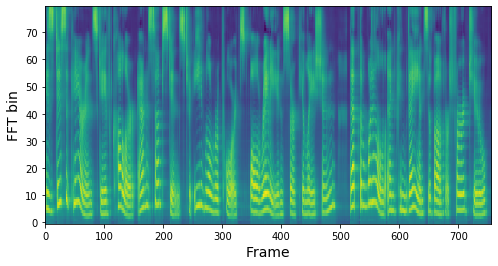

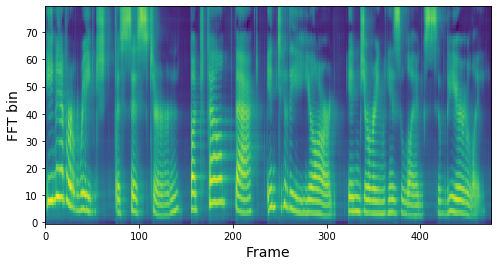

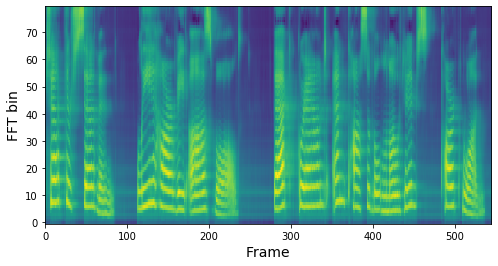

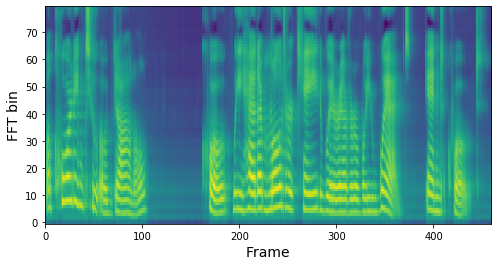

In [120]:
y_pred = model(x, y[0])

common_name = 'prosody_11k_steps'

# audio_data = denoiser(audio, strength=0.02).data.cpu().numpy()
specs = []
with torch.no_grad():
    for i in range(y_pred[0].shape[0]):
        spec = trim_spec(y_pred[0][i,...])
        specs.append(spec.cpu())
        audio_data = waveglow.infer(spec.unsqueeze(0), sigma=0.666)
 
        audio_data = denoiser(audio_data, strength=0.02).data.cpu().numpy()
        save_audio(common_name + "_{}".format(i) + '.wav', audio_data)

        plot_spectrogram(common_name + "_{}".format(i) + '.png',
                         spec.float().data.cpu().numpy(),
                         figsize=(8, 4))


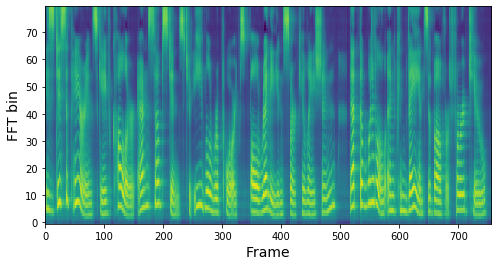

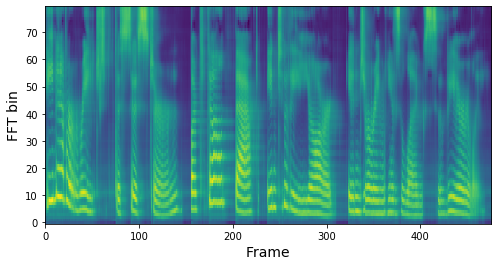

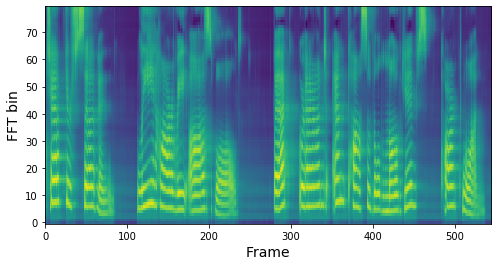

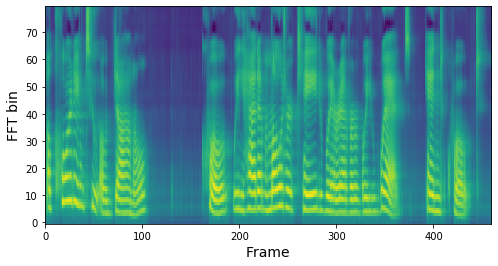

In [112]:
y_pred_transfer = model(x, y[0][(1,2,3,0),...])

common_name = 'prosody_11k_steps_transfer'

# audio_data = denoiser(audio, strength=0.02).data.cpu().numpy()
with torch.no_grad():
    for i in range(y_pred_transfer[0].shape[0]):
        spec_transfer = trim_spec(y_pred_transfer[0][i,...])
        audio_data = waveglow.infer(spec_transfer.unsqueeze(0), sigma=0.666)
 
        audio_data = denoiser(audio_data, strength=0.02).data.cpu().numpy()
        save_audio(common_name + "_{}".format(i) + '.wav', audio_data)

        plot_spectrogram(common_name + "_{}".format(i) + '.png',
                         spec_transfer.float().data.cpu().numpy(),
                         figsize=(8, 4))

### Let's try perturbing the reference encodings.

In [142]:


true_specs = [trim_spec(y[0][i,...]) for i in range(y[0].shape[0])]
embeddings = [model.reference_encoder(true_specs[i].unsqueeze(0)) for i in range(y[0].shape[0])]

In [144]:
print(embeddings[0]) 

tensor([ 0.2184,  0.3457, -0.4314, -0.1108,  0.3087, -0.0274, -0.0759,  0.5645,
        -0.2013, -0.5178,  0.4113, -0.2557,  0.5851, -0.0876,  0.3435, -0.2756,
         0.1126,  0.6532,  0.0798, -0.0324, -0.2575, -0.2365,  0.1068,  0.1902,
        -0.0294, -0.5683,  0.1464,  0.1195,  0.2974, -0.2341, -0.3032, -0.0852,
         0.0058,  0.4226,  0.0516,  0.2981, -0.3322, -0.1643,  0.4068,  0.0384,
        -0.1700,  0.1824, -0.2263,  0.0566,  0.3197, -0.3127,  0.2609,  0.1817,
         0.0346, -0.2831, -0.1044, -0.2451, -0.4870,  0.1793, -0.2735,  0.0845,
         0.2790, -0.0872,  0.1874,  0.4203,  0.0089, -0.2883, -0.0898,  0.5628,
        -0.0585,  0.1930,  0.2531,  0.0751, -0.5117, -0.1529, -0.0257, -0.6644,
         0.0870,  0.0101, -0.2622,  0.2670,  0.5330, -0.3080,  0.2090,  0.0932,
         0.0118,  0.3661,  0.2926,  0.6317, -0.0009,  0.0358, -0.0030,  0.2654,
        -0.6670,  0.0369, -0.1913, -0.3000,  0.3628, -0.2390, -0.0145, -0.5887,
         0.1721, -0.0114,  0.7465, -0.03

In [159]:
checkpoint_path_old = 'test-outdir/checkpoint_10000'
model_old = load_model(hparams)
model_old.load_state_dict(torch.load(checkpoint_path_old)['state_dict'])
embeddings = [model_old.reference_epytorch ncoder(true_specs[i].unsqueeze(0)) for i in range(y[0].shape[0])]
print(embeddings[0])

tensor([ 1.3785e-01,  2.5788e-01,  9.8062e-02, -2.8949e-01, -3.6861e-01,
         1.9325e-01, -1.6605e-01,  3.2737e-02, -1.0516e-01, -4.0736e-01,
        -4.6805e-03,  1.3587e-02,  2.2133e-01, -1.7291e-02, -2.7832e-01,
        -1.3061e-01, -2.0538e-02,  2.0979e-01,  1.7254e-02,  2.6133e-01,
        -2.6847e-01,  5.2495e-02,  1.1925e-02,  1.9453e-01,  9.9458e-03,
        -4.1072e-01,  4.9762e-01,  2.1389e-01, -1.6990e-01,  1.7501e-01,
        -3.5053e-01, -2.8685e-01, -1.0188e-01, -1.4761e-02,  3.2592e-01,
         1.9296e-01, -1.5290e-01,  7.3791e-02,  1.3685e-01,  2.2706e-01,
        -2.9780e-01,  1.5921e-01, -1.5603e-01, -1.1453e-01, -3.0034e-02,
        -1.5100e-01,  3.1989e-01,  1.5163e-01, -1.8706e-01,  9.9255e-02,
        -4.3447e-01, -6.8436e-02, -3.4480e-01,  8.8441e-03,  9.9554e-02,
         2.3697e-01,  5.0234e-02, -2.4035e-01,  2.7891e-01,  2.1752e-01,
        -2.5749e-01, -4.2973e-01, -2.3572e-01, -2.2226e-01,  1.2300e-02,
        -5.6224e-02,  1.7053e-01, -5.5357e-02, -1.2

In [185]:
model.reference_encoder

ReferenceEncoder(
  (activation): Tanh()
  (conv_block): ConvBlock(
    (layers): Sequential(
      (conv0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU()
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU()
      (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU()
      (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu3): ReLU()
      (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn4): BatchNorm2d(128, eps=1e-05, 

### Little tools for hotswapping the encoder module

In [193]:
class RandEncoder(nn.Module):
    def __init__(self, dimension):
        super(RandEncoder, self).__init__()
        self.dimension = dimension
    
    def forward(self, x):
        return 1e6 * torch.rand(self.dimension)
    
    
class EncoderContext():
    r"""Swap in a new encoder module on the fly with a `with` statement.
    """
    def __init__(self, model, encoder):
        self.model = model
        self.encoder = encoder
    
    def __enter__(self):
        self.old_encoder = self.model.reference_encoder
        self.model.reference_encoder = self.encoder.cuda()
    
    def __exit__(self, type, value, traceback):
        print('exiting')
        self.model.reference_encoder = self.old_encoder

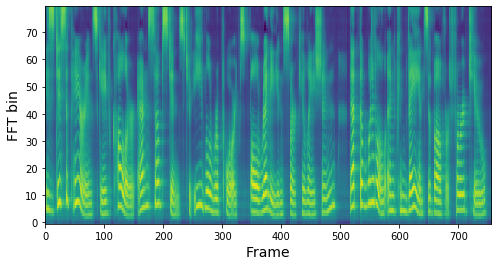

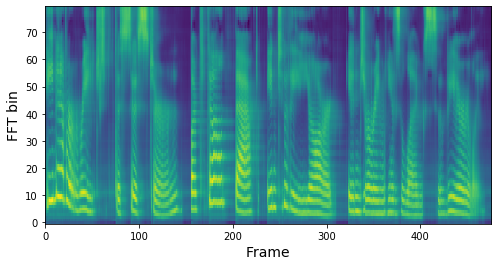

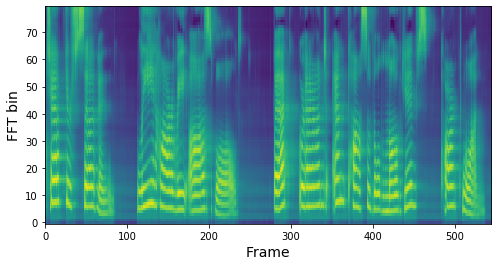

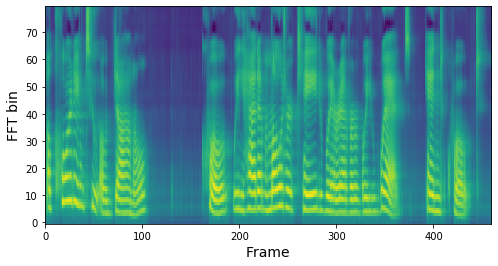

exiting


In [194]:
common_name = 'prosody_11k_steps_rand'

with EncoderContext(model, RandEncoder(128)):
    with torch.no_grad():
        for i in range(y_pred_transfer[0].shape[0]):
            spec_transfer = trim_spec(y_pred_transfer[0][i,...])
            audio_data = waveglow.infer(spec_transfer.unsqueeze(0), sigma=0.666)
 
            audio_data = denoiser(audio_data, strength=0.02).data.cpu().numpy()
            save_audio(common_name + "_{}".format(i) + '.wav', audio_data)

            plot_spectrogram(common_name + "_{}".format(i) + '.png',
                             spec_transfer.float().data.cpu().numpy(),
                             figsize=(8, 4))

#### Prepare text input

In [ ]:
text = "Institute has the finest professors."
sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()

#### Decode text input and plot results

In [ ]:
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)

In [ ]:
plot_data('triple_spectrogram.png',
          (mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

In [ ]:
common_name = 'institute_5k_steps'

with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
    data = audio[0].data.cpu().numpy()
    save_audio(common_name + '.wav', data)

plot_spectrogram(common_name + '.png',
                 mel_outputs_postnet.float().data.cpu().numpy()[0],
                 figsize=(8, 4))

#### Synthesize audio from spectrogram using WaveGlow

In [13]:
mel_outputs_postnet

NameError: name 'mel_outputs_postnet' is not defined

In [ ]:
with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

In [ ]:
#audio[0].data.cpu().numpy()
torch.__version__

#### (Optional) Remove WaveGlow bias

In [ ]:
audio_denoised = denoiser(audio, strength=0.01)[:, 0]
ipd.Audio(audio_denoised.cpu().numpy(), rate=hparams.sampling_rate) 